# This is the codebase for VASARI-auto

###	vasari-auto.py | a pipeline for automated VASARI characterisation of glioma

###	Copyright 2023 James Ruffle, High-Dimensional Neurology, UCL Queen Square Institute of Neurology.

###	This program is licensed under the APACHE 2.0 license

###	This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  

###	See the License for more details.

###	This code is part of the repository https://github.com/james-ruffle/vasari-auto

###	Correspondence to Dr James K Ruffle by email: j.ruffle@ucl.ac.uk

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/homebrew/opt/python@3.10/bin/python3.10
3.10.6 (main, Aug 30 2022, 04:58:14) [Clang 13.1.6 (clang-1316.0.21.2.5)]
sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)


In [2]:
#Import packages
import glob
import numpy as np
import os
import pandas as pd
import shutil
import errno
import subprocess
from datetime import datetime
from tqdm import tqdm
import argparse
import nibabel as nib
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import seaborn as sns
from sklearn.metrics import *
import time

In [3]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--path", type=str, default='//', help='path of subject data, default=/home/jruffle/patient_studies/')
# parser.add_argument("--nocleanup", action='store_true', help='whether to prevent clean-up of temporary files, disabled by default')
# args = parser.parse_args()

In [4]:
#where annotated nifti segmentations will be pulled from
seg_path = '/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/data/RADIOLOGISTS/IMAGES/'

#atlas paths
atlases = '/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/TUTORIAL/atlas_masks/'

#consultant neuroradiologist validation
df = pd.read_excel('/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/data/labelled_data/merged_radiologist_labelled_data.xlsx',index_col=0)

#segmentations to evaluate
model_prediction = '/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/'
neurorad_hand_label = '/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/neurorad_hand_label/'

# neurorad_hand_label_subs = sorted(glob.glob(neurorad_hand_label+'*gz'))
# model_prediction_subs = sorted(glob.glob(model_prediction+'*gz'))

neurorad_hand_label_subs = df['filename'].values

print("Number of lesions: "+str(len(neurorad_hand_label_subs)))
print('')
print('#unique lesions: '+str(len(df['filename'].unique())))
print('')
print('#number double reported for inter-rater variability: '+str(len(neurorad_hand_label_subs)-len(df['filename'].unique())))

Number of lesions: 100

#unique lesions: 87

#number double reported for inter-rater variability: 13


In [5]:
for i, row in df.iterrows():
    if 'UCSF' in df.loc[i,'filename']:
        print('yes')
        padded_num = row['filename'].split('-')[-1].zfill(4)
        df.loc[i,'filename'] = 'UCSF-PDGM-'+str(padded_num)

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [6]:
df.head()

,filename,OS,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,...,F14 Proportion of Oedema,F16 haemorrhage,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,F25 Calvarial modelling,COMMENTS
0,UPENN-GBM-00575_11,153,KPB,7m 40s,2,1,3,3.0,6,3,...,4,1,N/a,2,2,2,2,1,NaN,NaN
1,UPENN-GBM-00589_11,26,KPB,6m 6s,2,3,3,3.0,5,4,...,4,2,N/a,2,1,2,2,1,NaN,NaN
2,UPENN-GBM-00591_11,59,KPB,7m 3s,1,3,4,3.0,4,4,...,4,1,N/a,1,1,2,1,1,NaN,NaN
3,UPENN-GBM-00601_11,435,KPB,6m 23s,2,1,3,3.0,4,5,...,5,1,N/a,1,2,2,2,1,NaN,NaN
4,UPENN-GBM-00604_11,234,KPB,7m 10s,1,3,4,3.0,6,3,...,3,1,N/a,2,1,2,1,1,NaN,NaN


In [7]:
##derive anatomy masks - this is for automated location (F1)
brainstem = atlases+'brainstem.nii.gz'
brainstem = nib.load(brainstem)
brainstem_array = np.asanyarray(brainstem.dataobj)
brainstem_vol = np.sum(brainstem_array)

frontal_lobe = atlases+'frontal_lobe.nii.gz'
frontal_lobe = nib.load(frontal_lobe)
frontal_lobe_array = np.asanyarray(frontal_lobe.dataobj)
frontal_lobe_vol = np.sum(frontal_lobe_array)

insula = atlases+'insula.nii.gz'
insula = nib.load(insula)
insula_array = np.asanyarray(insula.dataobj)
insula_vol = np.sum(insula_array)

occipital = atlases+'occipital.nii.gz'
occipital = nib.load(occipital)
occipital_array = np.asanyarray(occipital.dataobj)
occipital_vol = np.sum(occipital_array)

parietal = atlases+'parietal.nii.gz'
parietal = nib.load(parietal)
parietal_array = np.asanyarray(parietal.dataobj)
parietal_vol = np.sum(parietal_array)

temporal = atlases+'temporal.nii.gz'
temporal = nib.load(temporal)
temporal_array = np.asanyarray(temporal.dataobj)
temporal_vol = np.sum(temporal_array)

thalamus = atlases+'thalamus.nii.gz'
thalamus = nib.load(thalamus)
thalamus_array = np.asanyarray(thalamus.dataobj)
thalamus_vol = np.sum(thalamus_array)

corpus_callosum = atlases+'corpus_callosum.nii.gz'
corpus_callosum = nib.load(corpus_callosum)
corpus_callosum_array = np.asanyarray(corpus_callosum.dataobj)
corpus_callosum_vol = np.sum(corpus_callosum_array)

ventricles = atlases+'ventricles.nii.gz'
ventricles = nib.load(ventricles)
ventricles_array = np.asanyarray(ventricles.dataobj)
ventricles_vol = np.sum(ventricles_array)

internal_capsule = atlases+'internal_capsule.nii.gz'
internal_capsule = nib.load(internal_capsule)
internal_capsule_array = np.asanyarray(internal_capsule.dataobj)
internal_capsule_vol = np.sum(internal_capsule_array)

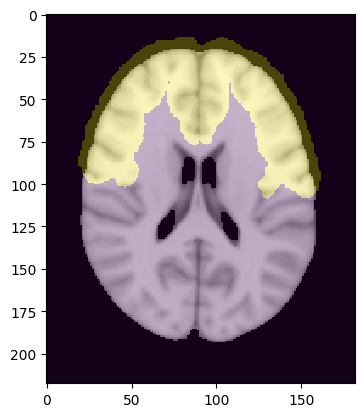

In [8]:
#let's plot a mask of the frontal lobe on the template to check it looks reasonable and visualise what we are doing
reference_brain = atlases+'MNI152_T1_1mm_brain.nii.gz'
reference_brain = nib.load(reference_brain)
reference_brain_array = np.asanyarray(reference_brain.dataobj)

ndimage.rotate(reference_brain_array[:,:,91], 90)

im1 = plt.imshow(ndimage.rotate(reference_brain_array[:,:,91], 90), cmap='Greys_r', interpolation='nearest')
im2 = plt.imshow(ndimage.rotate(frontal_lobe_array[:,:,91], 90), interpolation='nearest',vmin=0.9,alpha=.3)
plt.show()

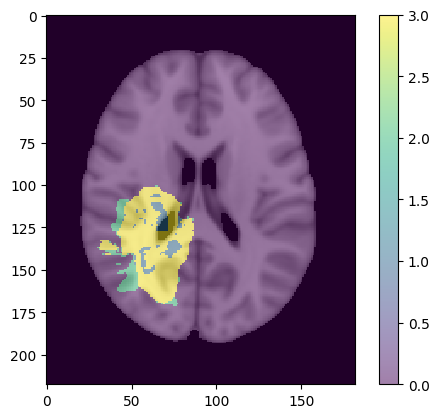

In [9]:
#let's plot one of the tumour segmentastions on the reference atlas
reference_brain = atlases+'MNI152_T1_1mm_brain.nii.gz'
reference_brain = nib.load(reference_brain)
reference_brain_array = np.asanyarray(reference_brain.dataobj)

ndimage.rotate(reference_brain_array[:,:,91], 90)

im1 = plt.imshow(ndimage.rotate(reference_brain_array[:,:,91], 90), cmap=plt.cm.gray, interpolation='nearest')

i=0
tumour = np.asanyarray(nib.load(neurorad_hand_label+neurorad_hand_label_subs[i]+'.nii.gz').dataobj)

im2 = plt.imshow(ndimage.rotate(tumour[:,:,91], 90), interpolation='nearest',alpha=.5,cmap='viridis')
cbar = plt.colorbar()

plt.show()

#on the segmentation, these are the following labels
# enhancing tumour = 3 (yellow bits)
# nonenhancing tumour = 1 (blue bit)
# oedema = 2 (green bit)

In [10]:
new_dataframe_for_modelling = pd.DataFrame(columns=df.columns)
new_dataframe_for_modelling['filename']=neurorad_hand_label_subs
new_dataframe_for_modelling['neurorad_hand_label']=neurorad_hand_label+neurorad_hand_label_subs+'.nii.gz'
new_dataframe_for_modelling['AUTOMATED_ANONYMISED_FILENAME']=model_prediction+neurorad_hand_label_subs+'.nii.gz'
new_dataframe_for_modelling.head()

,filename,OS,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,...,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,F25 Calvarial modelling,COMMENTS,neurorad_hand_label,AUTOMATED_ANONYMISED_FILENAME
0,UPENN-GBM-00575_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/jamesruffle/Library/CloudStorage/OneDri...,/Users/jamesruffle/Library/CloudStorage/OneDri...
1,UPENN-GBM-00589_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/jamesruffle/Library/CloudStorage/OneDri...,/Users/jamesruffle/Library/CloudStorage/OneDri...
2,UPENN-GBM-00591_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/jamesruffle/Library/CloudStorage/OneDri...,/Users/jamesruffle/Library/CloudStorage/OneDri...
3,UPENN-GBM-00601_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/jamesruffle/Library/CloudStorage/OneDri...,/Users/jamesruffle/Library/CloudStorage/OneDri...
4,UPENN-GBM-00604_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/Users/jamesruffle/Library/CloudStorage/OneDri...,/Users/jamesruffle/Library/CloudStorage/OneDri...


In [ ]:
def get_vasari_features(file,verbose=True,enhancing_label=3,nonenhancing_label=1,oedema_label=2,z_dim=-1,cf=0,t_ependymal=7500,t_wm=1):
    """
    file - NIFTI segmentation file with binary lesion labels
    verbose - whether to enable verbose logging, default=False
    enhancing_label - the integer value of enhancing tumour within file, default=3
    nonenhancing_label - the integer value of nonenhancing tumour within file, default=1
    oeedema_label - the integer value of nonenhancing tumour within file, default=2
    z_dim - the dimension of the Z axis within file, default=-1, which assumes MNI template registration
    cf - correction factor for ambiguity in voxel quantification, default=0
    t_ependymal - threshold for lesion involvement within the ependyma, this can be customised depending on the voxel resolution you are operating in, default=7500
    t_wm - threshold for lesion involvement within the wm, this can be customised depending on the voxel resolution you are operating in, default=1
    """
    
    start_time = time.time()
    
    if verbose:
        print('Working on: '+str(file))
    
    segmentation = nib.load(file)
    segmentation_array = np.asanyarray(segmentation.dataobj)
    
    if verbose:
        print('Running voxel quantification per tissue class')
    total_lesion_burden = np.count_nonzero(segmentation_array)
    enhancing_voxels = np.count_nonzero(segmentation_array == enhancing_label)
    nonenhancing_voxels = np.count_nonzero(segmentation_array == nonenhancing_label)
    oedema_voxels = np.count_nonzero(segmentation_array == oedema_label)
    
    
    if verbose:
        print('Deriving number of components')
    labeled_array, num_components = label(segmentation_array)
    
    if verbose:
        print('Determining laterality')
        print('Note - if experiencing unexpected axis flipping for lesion laterality, check lesion registration space. This code assumes MNI template registration')
    temp = segmentation_array.nonzero()[0]
    right_hemisphere=len(temp[temp<int(segmentation_array.shape[z_dim]/2)])
    left_hemisphere=len(temp[temp>int(segmentation_array.shape[z_dim]/2)])
    if right_hemisphere>left_hemisphere:
        side='Right'
    if right_hemisphere<left_hemisphere:
        side='Left'

    if verbose:
        print('Determining proportions')
    segmentation_array[segmentation_array==2]=0
    segmentation_array[segmentation_array==3]=1

    prop_in_brainstem = len((segmentation_array*brainstem_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_frontal_lobe = len((segmentation_array*frontal_lobe_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_insula = len((segmentation_array*insula_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_occipital = len((segmentation_array*occipital_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_parietal = len((segmentation_array*parietal_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_temporal = len((segmentation_array*temporal_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_thalamus = len((segmentation_array*thalamus_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)
    prop_in_cc = len((segmentation_array*corpus_callosum_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+cf)

    d = {'ROI': ['Brainstem','Frontal Lobe','Insula','Occipital Lobe','Parietal Lobe','Temporal Lobe','Thalamus','Corpus callosum'], 
         'prop': [prop_in_brainstem,prop_in_frontal_lobe,prop_in_insula,prop_in_occipital,prop_in_parietal,prop_in_temporal,prop_in_thalamus,prop_in_cc]}
    
    vols = pd.DataFrame(data=d)
    vols = vols.sort_values(by='prop',ascending=False).reset_index(drop=True)
    
    proportion_enhancing = (enhancing_voxels/total_lesion_burden)*100
    proportion_nonenhancing = (nonenhancing_voxels/total_lesion_burden)*100
    
    if verbose:
        print('Determining ependymal involvement')
    if len((segmentation_array*ventricles_array).nonzero()[0])>=t_ependymal:
        ependymal='Present'

    if len((segmentation_array*ventricles_array).nonzero()[0])<t_ependymal:
        ependymal='Absent'

    if verbose:
        print('Determining white matter involvemenet')
    deep_wm='None'
    if len((segmentation_array*brainstem_array).nonzero()[0])>=t_wm:
        deep_wm='Brainstem'

    if len((segmentation_array*corpus_callosum_array).nonzero()[0])>=t_wm:
        deep_wm='Corpus Callosum'

    if len((segmentation_array*internal_capsule_array).nonzero()[0])>=t_wm:
        deep_wm='Internal Capsule'
        
    end_time = time.time()
    if verbose:
        print(f"Time taken for data {i}: {end_time - start_time} seconds")
    time_taken.append(end_time - start_time)
        
    if verbose:
        print('Generating output')

In [23]:
col_names = ['filename', 'reporter', 'time_taken_seconds',
       'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
       'F3 Eloquent Brain', 'F4 Enhancement Quality',
       'F5 Proportion Enhancing', 'F6 Proportion nCET',
       'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
       'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
       'F12 Definition of the Enhancing margin',
       'F13 Definition of the non-enhancing tumour margin',
       'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
       'F18 Pial invasion', 'F19 Ependymal Invasion',
       'F20 Cortical involvement', 'F21 Deep WM invasion', 'F24 satellites',
       'F25 Calvarial modelling', 'COMMENTS']

result = pd.DataFrame(columns=col_names)
result.loc[len(result)] = {'filename':file,
                           'reporter':'VASARI-auto',
                          'time_taken_seconds':time_taken,
                          'F1 Tumour Location':vols.iloc[0,0],
                          'F2 Side of Tumour Epicenter':side,
                          'F3 Eloquent Brain':np.nan, #to codify with eloquency mask
                          'F4 Enhancement Quality':np.nan, # to codify with quantity determinant
                          'F5 Proportion Enhancing':proportion_enhancing,
                          'F6 Proportion nCET':proportion_nonenhancing,
                          'F7 Proportion Necrosis':proportion_nonenhancing,
                          'F8 Cyst(s)':np.nan, #for future versions,
                          }
result

ValueError: DataFrame constructor not properly called!

In [19]:
#     new_dataframe_for_modelling.loc[i,'AUTOMATED_ANONYMISED_FILENAME']=str(i)+'.nii.gz'
    new_dataframe_for_modelling.loc[i,'AUTOMATED_tumour_voxels']=total_lesion_burden
    new_dataframe_for_modelling.loc[i,'AUTOMATED_enhancing_tumour_voxels']=enhancing_voxels
    new_dataframe_for_modelling.loc[i,'AUTOMATED_nonenhancing_tumour_voxels']=nonenhancing_voxels
    new_dataframe_for_modelling.loc[i,'AUTOMATED_oedema_voxels']=oedema_voxels
    new_dataframe_for_modelling.loc[i,'AUTOMATED_number_components']=num_components
    new_dataframe_for_modelling.loc[i,'AUTOMATED_side_of_tumour']=side
    new_dataframe_for_modelling.loc[i,'AUTOMATED_tumour_location']=vols.iloc[0,0]
    new_dataframe_for_modelling.loc[i,'AUTOMATED_ependymal']=ependymal
    new_dataframe_for_modelling.loc[i,'AUTOMATED_deep_WM']=deep_wm
    
    end_time = time.time()
    print(f"Time taken for data {i}: {end_time - start_time} seconds")
    time_taken.append(end_time - start_time)

,ROI,prop
0,Parietal Lobe,0.619441
1,Temporal Lobe,0.216051
2,Occipital Lobe,0.082106
3,Corpus callosum,0.070007
4,Thalamus,0.026123
5,Brainstem,0.002738
6,Frontal Lobe,0.000000
7,Insula,0.000000


In [12]:
time_taken = []

for i, row in new_dataframe_for_modelling.iterrows():
    start_time = time.time()
    print("Working on subject "+ str(i))
    
    file = row['AUTOMATED_ANONYMISED_FILENAME']
    print(file)
    
#     new_dataframe_for_modelling.loc[i,'AUTOMATED_ANONYMISED_FILENAME']= file
    
    segmentation = nib.load(file)
    segmentation_array = np.asanyarray(segmentation.dataobj)
    total_lesion_burden = np.count_nonzero(segmentation_array)
    enhancing_voxels = np.count_nonzero(segmentation_array == 3)
    nonenhancing_voxels = np.count_nonzero(segmentation_array == 1)
    oedema_voxels = np.count_nonzero(segmentation_array == 2)
    labeled_array, num_components = label(segmentation_array)

    temp = segmentation_array.nonzero()[0]
    right_hemisphere=len(temp[temp<90])
    left_hemisphere=len(temp[temp>90])

    if right_hemisphere>left_hemisphere:
        side='Right'
    if right_hemisphere<left_hemisphere:
        side='Left'

    segmentation_array[segmentation_array==2]=0
    segmentation_array[segmentation_array==3]=1

    prop_in_brainstem = len((segmentation_array*brainstem_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_frontal_lobe = len((segmentation_array*frontal_lobe_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_insula = len((segmentation_array*insula_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_occipital = len((segmentation_array*occipital_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_parietal = len((segmentation_array*parietal_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_temporal = len((segmentation_array*temporal_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_thalamus = len((segmentation_array*thalamus_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)
    prop_in_cc = len((segmentation_array*corpus_callosum_array).nonzero()[0])/(enhancing_voxels+nonenhancing_voxels+50)

    d = {'ROI': ['Brainstem','Frontal Lobe','Insula','Occipital Lobe','Parietal Lobe','Temporal Lobe','Thalamus','Corpus callosum'], 'prop': [prop_in_brainstem,
                                                                                                            prop_in_frontal_lobe,
                                                                                                            prop_in_insula,
                                                                                                            prop_in_occipital,
                                                                                                            prop_in_parietal,
                                                                                                            prop_in_temporal,
                                                                                                            prop_in_thalamus,
                                                                                                                                             prop_in_cc]}

    vols = pd.DataFrame(data=d)
    vols = vols.sort_values(by='prop',ascending=False).reset_index(drop=True)

    t=7500 #a threshold for lesion volume within a structure, this can be customised
    if len((segmentation_array*ventricles_array).nonzero()[0])>=t:
        ependymal='Present'

    if len((segmentation_array*ventricles_array).nonzero()[0])<t:
        ependymal='Absent'

    t = 1
    deep_wm='None'
    if len((segmentation_array*brainstem_array).nonzero()[0])>=t:
        deep_wm='Brainstem'

    if len((segmentation_array*corpus_callosum_array).nonzero()[0])>=t:
        deep_wm='Corpus Callosum'

    if len((segmentation_array*internal_capsule_array).nonzero()[0])>=t:
        deep_wm='Internal Capsule'
        
#     new_dataframe_for_modelling.loc[i,'AUTOMATED_ANONYMISED_FILENAME']=str(i)+'.nii.gz'
    new_dataframe_for_modelling.loc[i,'AUTOMATED_tumour_voxels']=total_lesion_burden
    new_dataframe_for_modelling.loc[i,'AUTOMATED_enhancing_tumour_voxels']=enhancing_voxels
    new_dataframe_for_modelling.loc[i,'AUTOMATED_nonenhancing_tumour_voxels']=nonenhancing_voxels
    new_dataframe_for_modelling.loc[i,'AUTOMATED_oedema_voxels']=oedema_voxels
    new_dataframe_for_modelling.loc[i,'AUTOMATED_number_components']=num_components
    new_dataframe_for_modelling.loc[i,'AUTOMATED_side_of_tumour']=side
    new_dataframe_for_modelling.loc[i,'AUTOMATED_tumour_location']=vols.iloc[0,0]
    new_dataframe_for_modelling.loc[i,'AUTOMATED_ependymal']=ependymal
    new_dataframe_for_modelling.loc[i,'AUTOMATED_deep_WM']=deep_wm
    
    end_time = time.time()
    print(f"Time taken for data {i}: {end_time - start_time} seconds")
    time_taken.append(end_time - start_time)
    

Working on subject 0
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00575_11.nii.gz
Time taken for data 0: 0.8118987083435059 seconds
Working on subject 1
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00589_11.nii.gz
Time taken for data 1: 0.792917013168335 seconds
Working on subject 2
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00591_11.nii.gz
Time taken for data 2: 0.8672828674316406 seconds
Working on subject 3
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00601_11.nii.gz
Time taken for data 3: 0.8202528953552246 seconds
Working on subject 4
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00604_11.nii.gz
Time taken for data 4: 0.7632558345794678 seconds
W

Time taken for data 41: 0.7194397449493408 seconds
Working on subject 42
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UCSF-PDGM-0357.nii.gz
Time taken for data 42: 0.6842329502105713 seconds
Working on subject 43
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00407_11.nii.gz
Time taken for data 43: 0.6793117523193359 seconds
Working on subject 44
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00354_11.nii.gz
Time taken for data 44: 0.7061879634857178 seconds
Working on subject 45
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00389_11.nii.gz
Time taken for data 45: 0.7164859771728516 seconds
Working on subject 46
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00400_11.n

Time taken for data 82: 0.7814748287200928 seconds
Working on subject 83
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00170_11.nii.gz
Time taken for data 83: 0.7784731388092041 seconds
Working on subject 84
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00173_11.nii.gz
Time taken for data 84: 0.8204638957977295 seconds
Working on subject 85
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00178_11.nii.gz
Time taken for data 85: 0.722930908203125 seconds
Working on subject 86
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00180_11.nii.gz
Time taken for data 86: 0.7861061096191406 seconds
Working on subject 87
/Users/jamesruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/UPENN-GBM-00242_1

In [14]:
new_dataframe_for_modelling

,filename,OS,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,...,AUTOMATED_ANONYMISED_FILENAME,AUTOMATED_tumour_voxels,AUTOMATED_enhancing_tumour_voxels,AUTOMATED_nonenhancing_tumour_voxels,AUTOMATED_oedema_voxels,AUTOMATED_number_components,AUTOMATED_side_of_tumour,AUTOMATED_tumour_location,AUTOMATED_ependymal,AUTOMATED_deep_WM
0,UPENN-GBM-00575_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,164797.0,87653.0,20140.0,57004.0,4.0,Right,Temporal Lobe,Present,Internal Capsule
1,UPENN-GBM-00589_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,48565.0,12721.0,7910.0,27934.0,2.0,Left,Temporal Lobe,Absent,None
2,UPENN-GBM-00591_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,39220.0,2619.0,662.0,35939.0,3.0,Left,Frontal Lobe,Absent,None
3,UPENN-GBM-00601_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,155802.0,21942.0,11179.0,122681.0,4.0,Right,Temporal Lobe,Absent,None
4,UPENN-GBM-00604_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,48856.0,25037.0,16469.0,7350.0,1.0,Left,Parietal Lobe,Absent,Internal Capsule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,UPENN-GBM-00326_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,235024.0,63839.0,82428.0,88757.0,1.0,Left,Frontal Lobe,Present,Internal Capsule
96,UPENN-GBM-00329_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,184825.0,21439.0,7298.0,156088.0,17.0,Right,Frontal Lobe,Absent,Internal Capsule
97,UPENN-GBM-00335_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,15462.0,4053.0,2399.0,9010.0,2.0,Left,Temporal Lobe,Absent,Brainstem
98,UPENN-GBM-00342_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/Users/jamesruffle/Library/CloudStorage/OneDri...,71963.0,2511.0,58.0,69394.0,10.0,Right,Temporal Lobe,Absent,None
